# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely
import matplotlib.pyplot as plt

%matplotlib inline

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [2]:
from shapely.geometry import Polygon

In [3]:
square_points = [[2,2],[2,5],[5,5],[5,2]]
square = Polygon(square_points)
triangle_point = [[0,0], [4,0], [2,4]]
triangle = Polygon(triangle_point)

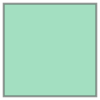

In [4]:
square

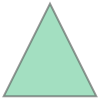

In [5]:
triangle

> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

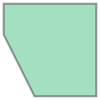

In [6]:
#Difference
square - triangle

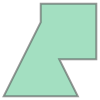

In [7]:
#Union
square | triangle

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

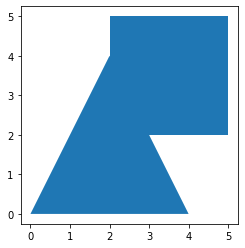

In [8]:
gpd.GeoSeries([square, triangle]).plot()

### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS (Coordinate References System) of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [9]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

In [10]:
municipal = gpd.read_file(url)
#Print the CRS of the data - it is the standard GPS CRS which calculates distance based on degrees
print('Initial CRS:', municipal.crs)

#Set to meter based system
municipal.to_crs(epsg = '25832', inplace = True)
print('Metric CRS:', municipal.crs) # Don't know what 'no_defs = True' is...

#Area - det blev lidt knudret
area_municipal = {}
for kom in municipal.groupby('KOMNAVN').geometry: # Loop though each municipality
    poly_area = []
    for poly in kom[1]: # Loop through the polygons of the municipality
        poly_area.append(poly.area) # Calc area and store
    area_municipal[kom[0]] = sum(poly_area) # Append municipality and summed area to dict

#Find the 3 largest - don't know how else so get the keys for the 3 largest values of the dict.
three_largest = pd.DataFrame(area_municipal, index = ['Area'])\
                             .transpose().sort_values('Area',ascending = False).head(3)

print('\n\n 3 largest municipalities:', three_largest)

Initial CRS: {'init': 'epsg:4326'}
Metric CRS: {'init': 'epsg:25832', 'no_defs': True}


 3 largest municipalities:                            Area
Ringkøbing-Skjern  1.494151e+09
Viborg             1.419631e+09
Herning            1.323127e+09


In [11]:
# Kristians måde - lidt smartere
sizes = municipal.groupby('KOMNAVN').geometry.apply(lambda d: d.unary_union.area)
sizes.nlargest(3)

KOMNAVN
Ringkøbing-Skjern    1.494151e+09
Viborg               1.419631e+09
Herning              1.323127e+09
Name: geometry, dtype: float64

Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [12]:
municipal.columns = municipal.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

municipal = municipal\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [13]:
#Region sjælland og Hovedstaden
municipal['first'] = municipal['regionsnavn'].isin(['Region Hovedstaden', 'Region Sjælland'])
#Notin Bornholm og Christiansø
municipal['second'] = ~municipal['komnavn'].isin(['Bornholm', 'Christiansø'])
#Both true
municipal['final'] = municipal['first'] & municipal['second']
#Zealand subset
sealand_df = municipal[municipal.final == True]

> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [14]:
sealand_df.crs

{'init': 'epsg:25832', 'no_defs': True}

The CRS is still the meter based system - the geometric space is then 2d.

Distance is measured using the euclidean distance metric, which is simply the length of a straight line between the points of the polygons. Thus it makes sense to assume that the space i 2-dimensional. 

minx    6.172880e+05
miny    6.049782e+06
maxx    7.392600e+05
maxy    6.231608e+06
dtype: float64


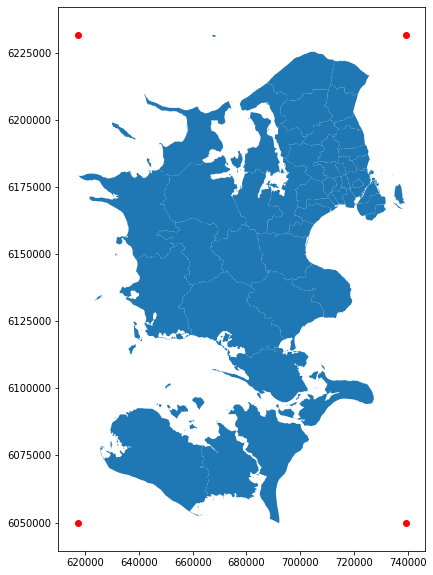

In [15]:
minimum = sealand_df.bounds[['minx', 'miny']].apply(min, axis = 0) # The minimum values
maximum = sealand_df.bounds[['maxx', 'maxy']].apply(max, axis = 0) # The maximum values

bounds = pd.concat([minimum, maximum])
#The bounds - could have also just used: 'sealand_df.total_bounds'
print(bounds)

#Plot
sealand_df.plot(figsize = (10,10))
plt.scatter([bounds.minx, bounds.minx, bounds.maxx, bounds.maxx],
            [bounds.miny, bounds.maxy, bounds.miny, bounds.maxy], c='r')

#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [16]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [17]:
#Coordinates for the lower left corner of the 500 squares
square_lower_left_coords = [(x,y) for x in np.arange(bounds.minx, bounds.maxx, 500) for y in np.arange(bounds.miny, bounds.maxy, 500)]

#Convert the coordinates to Dataframe
square_df = pd.DataFrame(data=square_lower_left_coords, columns=['e', 'n'])
#Convert to coordinates to polygons for 
square_df = cell_coords_to_polygons(square_df)
#Convert to same crs
sealand_df.to_crs({'init':'epsg:25832'}, inplace=True)
square_df.to_crs({'init':'epsg:25832'}, inplace=True)
#exlude to squares which are not covering land, but ocean
square_gdf_s = gpd.sjoin(square_df, sealand_df)
#Får alle mulige warning

/Users/Esben/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level
/Users/Esben/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


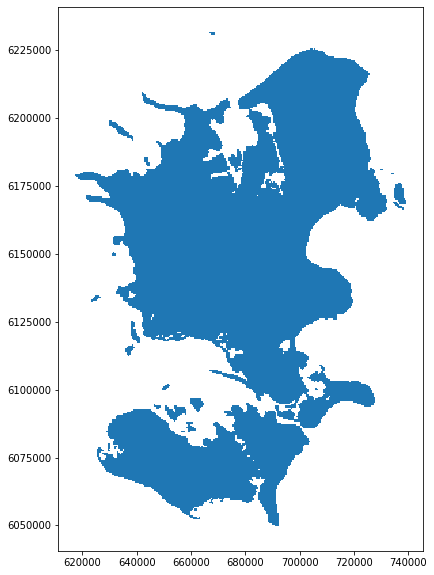

In [18]:
square_gdf_s.plot(figsize = (10,10))
#Plottet ser fint ud til trods for warnings osv. 

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

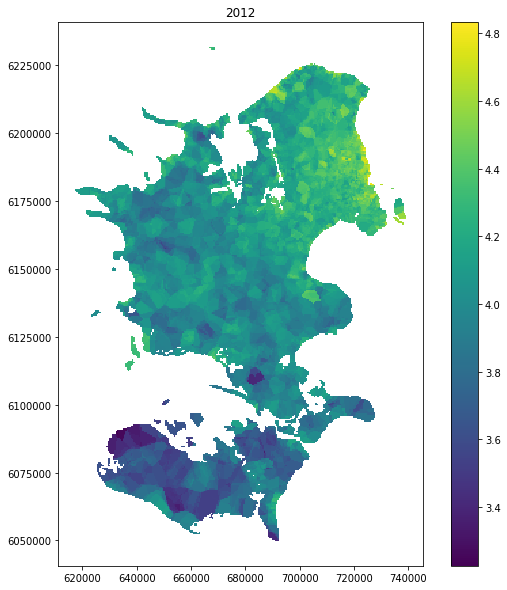

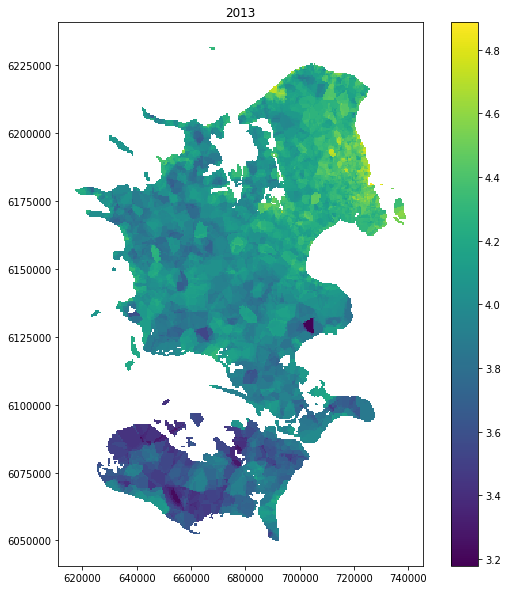

In [19]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')
#Specify relevant columns:
rel_col = ['sale_year', 'e', 'n', 'price_area']
#Loop for each year
for year in price_gdf.sale_year.unique():
    #specify year and price_area
    sub_df = price_gdf[(price_gdf.sale_year == year) &
              (price_gdf.price_area <= 120000) &
              (price_gdf.price_area >= 1000)]
    sub_df = sub_df.loc[:,rel_col] # Specify columns
    sub_df = sub_df.dropna(axis = 0) # Drop nan
    # Prepare for K-nearest
    feat = sub_df[['e','n']]
    target = sub_df['price_area']
    knn = KNeighborsRegressor(n_neighbors = 5)
    #Fit model
    knn.fit(feat, target)
    #Predict
    preds = knn.predict(square_gdf_s[['e','n']] + 250)
    square_gdf_s['p_{}'.format(year)] = np.log10(preds)
    #Plot
    square_gdf_s.plot(column = 'p_{}'.format(year), figsize = (10,10), legend = True).set_title('{}'.format(year))